# ConvLM

A temporal convolutional language model is trained

In [1]:
# % load_ext autoreload
# % autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch import nn

In [3]:
from lm.data import LMDataLoader
from lm.models import ConvLM, accuracy
from lm.schedulers import OneCycle

In [4]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

Loading the data, making dataloaders

In [5]:
dict_path = Path('word2int.pickle')
with dict_path.open('rb') as file:
    d = pickle.load(file)

In [6]:
xtrain = np.load('wikitext_train_int_tokens.npy')
xval = np.load('wikitext_valtest_int_tokens.npy')

In [7]:
xtrain_tensor = torch.from_numpy(xtrain).long()
xval_tensor = torch.from_numpy(xval).long()

if device.type == 'cuda':
    xtrain_tensor = xtrain_tensor.cuda()
    xval_tensor = xval_tensor.cuda()

In [8]:
train_dataloader = LMDataLoader(xtrain_tensor, 70, 64)
val_dataloader = LMDataLoader(xval_tensor, 70, 64)

In [9]:
vocab_size = len(d)
padding_idx = d['_pad_']

In [10]:
model = ConvLM(embedding_dropout=0.1, num_blocks=2, vocab_size=vocab_size, padding_idx=padding_idx).cuda()

In [11]:
model

ConvLM(
  (embedding): VDEmbedding(
    (embedding): Embedding(30002, 400, padding_idx=0)
  )
  (TCNBlock_0): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(1,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 1150, kernel_size=(2,), stride=(1,), padding=(1,))
    )
    (conv3): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(1,))
    )
  )
  (TCNBlock_1): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 1150, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
    (conv3): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
  )
  (decoder): Linear(in_features=400, out_features=30002, bias=True)
  (emb_drop): VariationalDropout()
)

Finally, define our losses

In [12]:
crit = nn.CrossEntropyLoss()

Now, a first round of training, to make sure everything actually works.

In [13]:
optimizer = torch.optim.Adam(model.parameters())

In [14]:
starting_learning_rate = 1e-5
ending_learning_rate = 1

info = defaultdict(list)

for batch_number, batch in (enumerate(tqdm(train_dataloader))):
    
    addition = (batch_number / len(train_dataloader)) * (ending_learning_rate - starting_learning_rate)
    learning_rate = starting_learning_rate + addition
    # update the optimizer learning rates
    for g in optimizer.param_groups:
        g['lr'] = learning_rate
    info['lr'].append(learning_rate)
    # Zero the gradients of my optimizer - 'reset' it
    optimizer.zero_grad()

    x, y = batch
    pred = model(x)

    loss = crit(pred, y)
    acc = accuracy(pred, y)

    info['loss'].append(loss.item())
    info['accuracy'].append(acc)
    
    loss.backward()
    optimizer.step()

 92%|█████████▏| 475/514 [01:45<00:08,  4.51it/s]


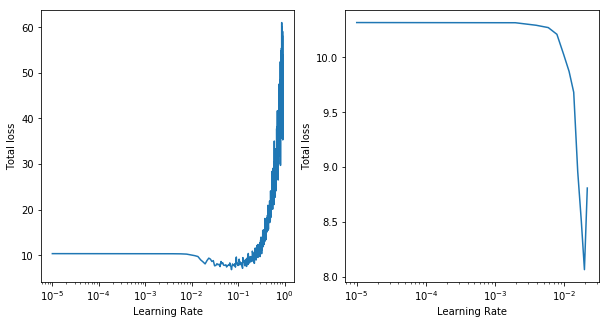

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(info['lr'], info['loss'])
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(info['lr'][:12], info['loss'][:12])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

In [14]:
scheduler = OneCycle(optimizer, len(train_dataloader), upswing=2, downswing=18, min_lr=1e-5,
                     max_lr=1e-2)

In [15]:
num_epochs = scheduler.num_epochs()

In [16]:
overall_train = defaultdict(list)
overall_val = defaultdict(list)

for epoch in range(num_epochs):
    # set the model to train
    model.train()
    # keep track of training scores, so they can be displayed later
    train_scores = defaultdict(list)
    
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()
        
        x, y = batch
        pred = model(x)
        
        loss = crit(pred, y)
        acc = accuracy(pred, y)
        
        train_scores['loss'].append(loss.item())
        train_scores['accuracy'].append(acc)
        
        total_loss = loss
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_output_strings = []
    for key, val in train_scores.items():
        mean_value = np.array(val).mean()
        train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
        overall_train[key].append(mean_value)
        
    if val_dataloader:
        model.eval()
        val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in enumerate(val_dataloader):
                x, y = batch
                pred = model(x)
                val_loss = crit(pred, y)
                acc = accuracy(pred, y)
                
                val_scores['loss'].append(val_loss)
                val_scores['accuracy'].append(acc)
                
        val_output_strings = []
        for key, val in val_scores.items():
            mean_value = np.array(val).mean()
            val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
            overall_val[key].append(mean_value)
        print('TRAINING: {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}'.format(*val_output_strings))

  0%|          | 1/514 [00:00<01:35,  5.35it/s]

TRAINING: loss: 7.80028, accuracy: 0.0591
VALIDATION: loss: 6.96737003326416, accuracy: 0.07976


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.24588, accuracy: 0.07723
VALIDATION: loss: 6.88838005065918, accuracy: 0.088


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.34353, accuracy: 0.08533
VALIDATION: loss: 6.883699893951416, accuracy: 0.08849


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.32825, accuracy: 0.08452
VALIDATION: loss: 6.880410194396973, accuracy: 0.08768


  0%|          | 1/514 [00:00<01:38,  5.21it/s]

TRAINING: loss: 7.31579, accuracy: 0.08878
VALIDATION: loss: 6.9026198387146, accuracy: 0.08333


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.26816, accuracy: 0.08519
VALIDATION: loss: 6.91264009475708, accuracy: 0.09256


  0%|          | 1/514 [00:00<01:38,  5.22it/s]

TRAINING: loss: 7.2766, accuracy: 0.08633
VALIDATION: loss: 6.930669784545898, accuracy: 0.08973


  0%|          | 1/514 [00:00<01:06,  7.70it/s]

TRAINING: loss: 7.25719, accuracy: 0.08749
VALIDATION: loss: 6.799739837646484, accuracy: 0.09054


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.20522, accuracy: 0.08918
VALIDATION: loss: 6.885419845581055, accuracy: 0.09777


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.20115, accuracy: 0.08627
VALIDATION: loss: 6.824550151824951, accuracy: 0.09072


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.12202, accuracy: 0.08745
VALIDATION: loss: 6.848649978637695, accuracy: 0.09891


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.17554, accuracy: 0.08769
VALIDATION: loss: 6.839089870452881, accuracy: 0.0933


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.14471, accuracy: 0.09076
VALIDATION: loss: 6.857379913330078, accuracy: 0.08765


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.15161, accuracy: 0.08891
VALIDATION: loss: 6.901659965515137, accuracy: 0.09405


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.14893, accuracy: 0.0904
VALIDATION: loss: 6.991730213165283, accuracy: 0.0909


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.12413, accuracy: 0.09089
VALIDATION: loss: 6.893129825592041, accuracy: 0.0911


  0%|          | 1/514 [00:00<00:55,  9.27it/s]

TRAINING: loss: 7.05349, accuracy: 0.09019
VALIDATION: loss: 6.88431978225708, accuracy: 0.09581


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.07313, accuracy: 0.09455
VALIDATION: loss: 6.9388298988342285, accuracy: 0.09006


  0%|          | 0/514 [00:00<?, ?it/s]

TRAINING: loss: 7.06954, accuracy: 0.09062
VALIDATION: loss: 6.831429958343506, accuracy: 0.0936


 92%|█████████▏| 472/514 [01:46<00:09,  4.44it/s]


TRAINING: loss: 7.04457, accuracy: 0.08703
VALIDATION: loss: 6.887360095977783, accuracy: 0.08839


In [17]:
model_information = {'state_dict': model.state_dict()}
torch.save(model_information, 'ConvLM.pth.tar')

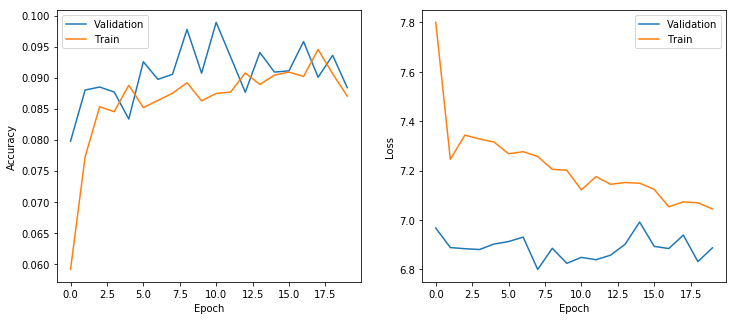

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# First, lets plot accuracy
axes[0].plot(range(len(overall_val['accuracy'])), overall_val['accuracy'], label='Validation')
axes[0].plot(range(len(overall_train['accuracy'])), overall_train['accuracy'], label='Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# then, loss
axes[1].plot(range(len(overall_val['loss'])), overall_val['loss'], label='Validation')
axes[1].plot(range(len(overall_train['loss'])), overall_train['loss'], label='Train')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()